In [1]:
# load the package
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, SetPyPlot, Dierckx, Statistics, BlackBoxOptim
import Calculus
import GR
FF = FractionalFlow

┌ Info: Precompiling PyPlot [d330b81b-6aea-500a-939a-2ce795aea3ee]
└ @ Base loading.jl:1273
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1273
┌ Info: Precompiling SetPyPlot [d6c70c59-9b85-50b1-926c-19fb5cf24e7d]
└ @ Base loading.jl:1273
┌ Warning: Package SetPyPlot does not have PyPlot in its dependencies:
│ - If you have SetPyPlot checked out for development and have
│   added PyPlot as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with SetPyPlot
└ Loading PyPlot into SetPyPlot from project dependency, future warnings for SetPyPlot are suppressed.


Main.FractionalFlow

# Water-flooding

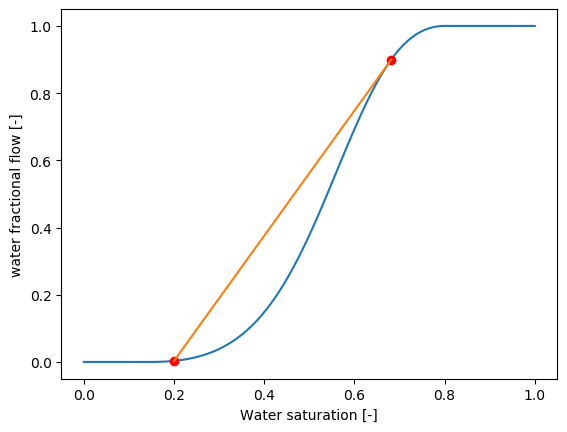

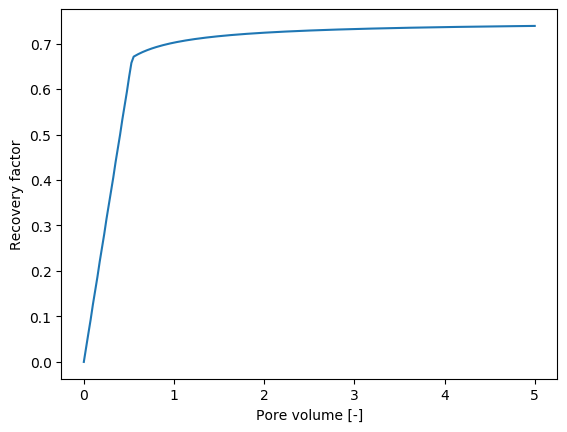

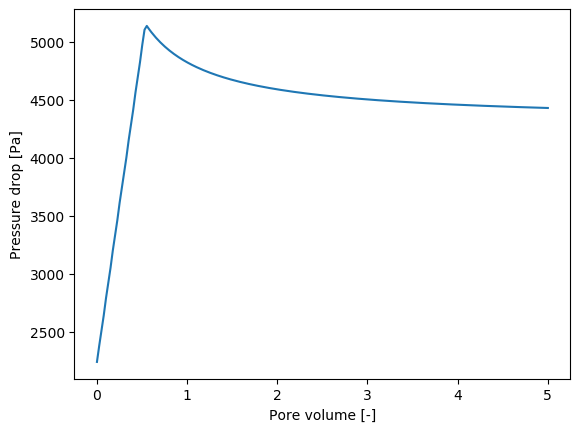

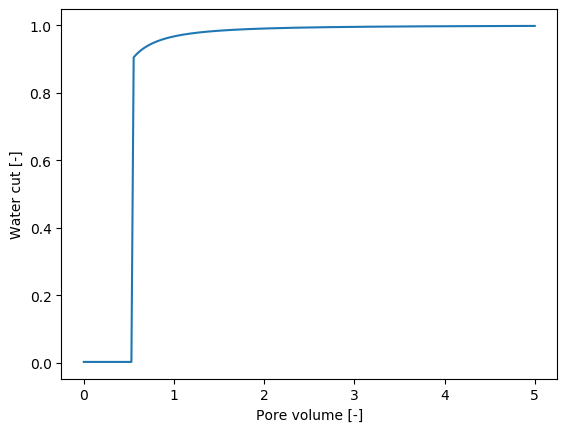

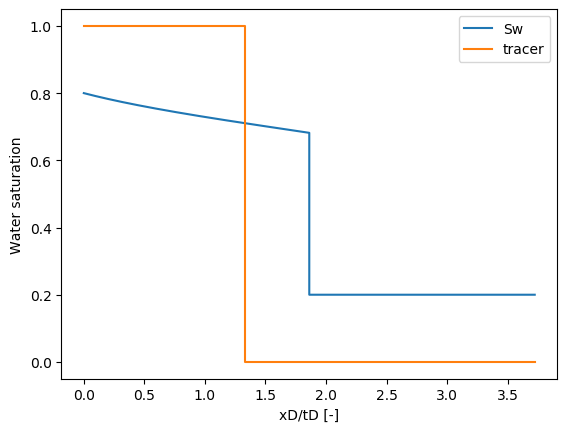

PyObject <matplotlib.legend.Legend object at 0x0000000032B77B38>

In [2]:
# define the problem
# relative permeabilities
rel_perms = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
    swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# FF.visualize(rel_perms)
# define the fluids
fluids = FF.oil_water_fluids(mu_water=1e-3, mu_oil=1e-3)

# define the fractional flow functions
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
# visualize the fractional flow
# FF.visualize(rel_perms, fluids, label="lowsal")
# tight_layout()
ut = 1.15e-5
phi = 0.3
L = 0.15
core_flood = FF.core_flooding(u_inj=1.15e-5, pv_inject=5, 
    p_back=1e5, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms)
core_props = FF.core_properties()
wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
fw, dfw = FF.fractional_flow_function(rel_perms, fluids)
sw_tmp = FF.linspace(0,1,100)

FF.visualize(wf_res)

In [3]:
t_sec, pv, rec_fact, dp_core, x, sw_face, c_face, c_out_sal=FF.water_flood_numeric(core_props, fluids, rel_perms, core_flood, Nx=50);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:09


# synthetic experimental data


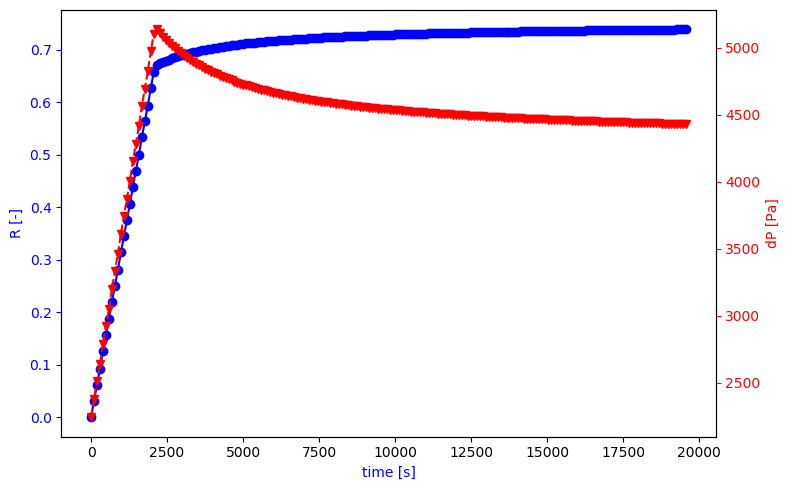

(Figure(PyObject <Figure size 800x500 with 2 Axes>), PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000032D38898>, PyObject <matplotlib.axes._subplots.AxesSubplot object at 0x0000000032DFF278>)

In [4]:
t_exp_dp = wf_res.dp_time[:,1]
dp_exp = wf_res.dp_time[:,2]
t_exp_R = wf_res.recovery_time[:,1]
R_exp = wf_res.recovery_time[:,2]
plotyy(t_exp_R, R_exp, t_exp_dp, dp_exp, fig_size = [8,5], x_label="time [s]", y1_label="R [-]", y2_label="dP [Pa]")

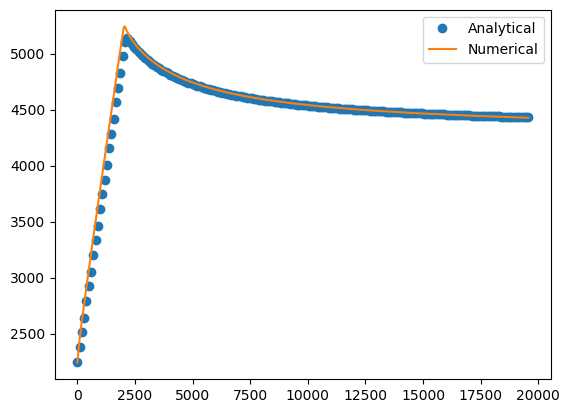

PyObject <matplotlib.legend.Legend object at 0x0000000031D666D8>

In [5]:
plot(t_exp_dp, dp_exp, "o", t_sec, dp_core)
legend(["Analytical", "Numerical"])

# define the objective function

In [6]:
# struct
struct exp_data
    t_exp_dp
    dp_exp
    t_exp_R
    R_exp
end
exp_data1 = exp_data(t_exp_dp, dp_exp, t_exp_R, R_exp);

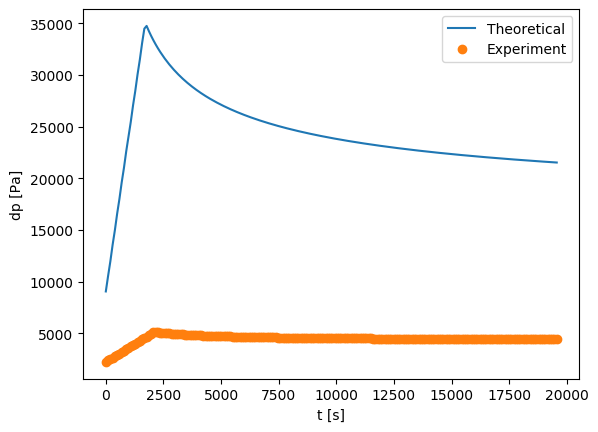

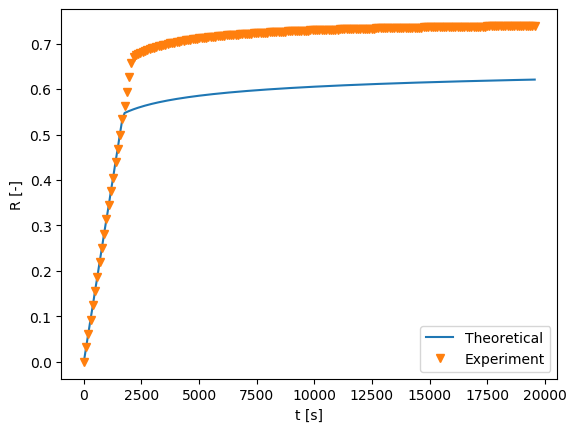

4.57679065373876

In [7]:
"""
rel_perm_param [krw0, kro0, nw, no, swc, sor]
"""
function error_calc(rel_perm_param, exp_data, core_props, fluids, core_flood; w_p=1.0, w_R=1.0)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    dp_calc = Spline1D(wf_res.dp_time[:,1], wf_res.dp_time[:,2], k=1, bc="nearest")
    R_calc = Spline1D(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], k=1, bc="nearest")
    error_dp = abs.(dp_calc(exp_data.t_exp_dp) .- exp_data.dp_exp)
#     println(error_dp)
    error_R = abs.(R_calc(exp_data.t_exp_R) .- exp_data.R_exp)
#     println(error_R)
    error_dp_norm = w_p.*error_dp./exp_data.dp_exp
    error_R_norm = w_R.*error_R./(exp_data.R_exp.+eps())
    return mean(error_R_norm)+mean(error_dp_norm)
end

function vis_error(rel_perm_param, exp_data, core_props, fluids, core_flood)
    rel_perms = FF.oil_water_rel_perms(krw0=rel_perm_param[1], kro0=rel_perm_param[2], 
    swc=rel_perm_param[5], sor=rel_perm_param[6], nw=rel_perm_param[3], no = rel_perm_param[4])
    wf_res = FF.water_flood(core_props, fluids, rel_perms, core_flood)
    figure()
    plot(wf_res.dp_time[:,1], wf_res.dp_time[:,2],  exp_data.t_exp_dp, exp_data.dp_exp, "o")
    xlabel("t [s]")
    ylabel("dp [Pa]")
    legend(["Theoretical", "Experiment"])
    
    figure()
    plot(wf_res.recovery_time[:,1], wf_res.recovery_time[:,2], exp_data.t_exp_R, exp_data.R_exp, "v")
    xlabel("t [s]")
    ylabel("R [-]")
    legend(["Theoretical", "Experiment"])
    
end

# test
x_init = [0.109681, 0.201297, 3.96653, 3.0, 0.19, 0.262231]

vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# define the objective function and gradients and weight factors

In [8]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
temp_val, ind_max = findmax(exp_data1.dp_exp)
println(ind_max)
w_p[ind_max-3:ind_max+3] .= 10
w_p[end-10:end] .= 10
w_p[1]=10
w_R = ones(length(exp_data1.R_exp))
w_R[20:25] .= 10
w_R[end-3:end] .= 10


function f(x)
    f_val = 0.0
    try
        f_val = error_calc(x, exp_data1, core_props, fluids, core_flood, w_p = w_p, w_R = w_R)
    catch
        f_val = 100.0
#         info("Objective function did not converge!")
    end
    return f_val
end

    
function g(x)
    eps1 = 1e-3
    f_val = f(x)
    g_val = ones(length(x))
    try
        # g_val = Calculus.gradient(x -> error_calc(x, exp_data1, core_props, fluids, core_flood), x)
        for j in eachindex(x)
            x2 = copy(x)
            x2[j]+=eps1
            f_val2 = f(x2)
            g_val[j] = (f_val2-f_val)/eps1
        end
    catch
        g_val = ones(length(x))
    end
    return g_val
end

function obj_fun(param, grad)
    if length(grad)>0
      grad[:] = g(param)
    end
    
    obj_fun_val = f(param)
    if isnan(obj_fun_val) || isinf(obj_fun_val)
        obj_fun_val = 100.0
    end
    return obj_fun_val
end

# test
grad_x = zeros(6)
obj_fun([1.0, 0.8, 3, 4, 0.2, 0.2], grad_x)

f([1.0, 0.8, 2, 2, 0.1, 0.2])

23


1.0713534659832842

In [9]:
grad_x

6-element Array{Float64,1}:
  0.559755747851276   
  0.007055679254075464
 -0.23785704697598664 
 -0.04586750588075894 
 -0.8425478566016498  
  1.8982879302710254  

In [10]:
x_init = [0.9, 0.8, 2.5, 2.5, 0.1, 0.1]
x_lb = [0.1, 0.1, 1.5, 1.5, 0.05, 0.1]
x_ub = [1.0, 1.0, 4.0, 4.0, core_flood.initial_water_saturation, 0.25]

res = bboptimize(f, SearchRange = [(0.1, 1.0), (0.1, 1.0), (1.5, 4.0), (1.5, 4.0), 
        (0.05, core_flood.initial_water_saturation), (0.1, 0.25)])
 
#    NumDimensions = 6, Method = :de_rand_1_bin)

# opt_alg=:LD_SLSQP
# opt1 = Opt(opt_alg, length(x_init)) # choose the algorithm
# lower_bounds!(opt1, x_lb)
# upper_bounds!(opt1, x_ub)
# ftol_rel!(opt1, 1e-15)
# ftol_abs!(opt1, 1e-15)

# min_objective!(opt1, obj_fun)
# (fObjOpt, paramOpt, flag) = optimize(opt1, x_init)

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64},RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.58 secs, 10 evals, 5 steps, improv/step: 0.800 (last = 0.8000), fitness=0.611312982
1.14 secs, 21 evals, 11 steps, improv/step: 0.727 (last = 0.6667), fitness=0.529325847
1.66 secs, 33 evals, 18 steps, improv/step: 0.556 (last = 0.2857), fitness=0.415254671
2.19 secs, 44 evals, 24 steps, improv/step: 0.500 (last = 0.3333), fitness=0.282775545
2.71 secs, 56 evals, 31 steps, improv/step: 0.516 (last = 0.5714), fitness=0.282775545
3.25 secs, 68 evals, 37 steps, improv/step: 0.514 (last = 0.5000), fitness=0.179274381
3.77 secs, 80 evals, 44 steps, improv/step: 0.523 (last = 0.5714), fitness=0.179274381
4.32 secs, 92 evals, 52 steps, improv/step: 0.500 (last = 0.3750), fitness=0.179274381
4.84 secs, 104 evals, 59 steps, improv/step: 0.508 (last = 0.5714), fitness=0.179274381
5.38 secs, 116 e

BlackBoxOptim.OptimizationResults("adaptive_de_rand_1_bin_radiuslimited", "Max number of steps (10000) reached", 10001, 1.575471113486e9, 487.8269999027252, DictChain{Symbol,Any}[DictChain{Symbol,Any}[Dict{Symbol,Any}(:RngSeed => 342670,:SearchRange => Tuple{Float64,Float64}[(0.1, 1.0), (0.1, 1.0), (1.5, 4.0), (1.5, 4.0), (0.05, 0.2), (0.1, 0.25)],:MaxSteps => 10000),Dict{Symbol,Any}()],Dict{Symbol,Any}(:FitnessScheme => ScalarFitnessScheme{true}(),:NumDimensions => :NotSpecified,:PopulationSize => 50,:MaxTime => 0.0,:SearchRange => (-1.0, 1.0),:Method => :adaptive_de_rand_1_bin_radiuslimited,:MaxNumStepsWithoutFuncEvals => 100,:RngSeed => 1234,:MaxFuncEvals => 0,:SaveTrace => false…)], 10085, ScalarFitnessScheme{true}(), BlackBoxOptim.TopListArchiveOutput{Float64,Array{Float64,1}}(2.3238332610212827e-5, [0.39999813542572393, 0.9064870289371078, 2.00825093694817, 1.9997457371433491, 0.1475451964727831, 0.2000090042657465]), BlackBoxOptim.PopulationOptimizerOutput{FitPopulation{Float64}

In [11]:
best_candidate(res)

6-element Array{Float64,1}:
 0.39999813542572393
 0.9064870289371078 
 2.00825093694817   
 1.9997457371433491 
 0.1475451964727831 
 0.2000090042657465 

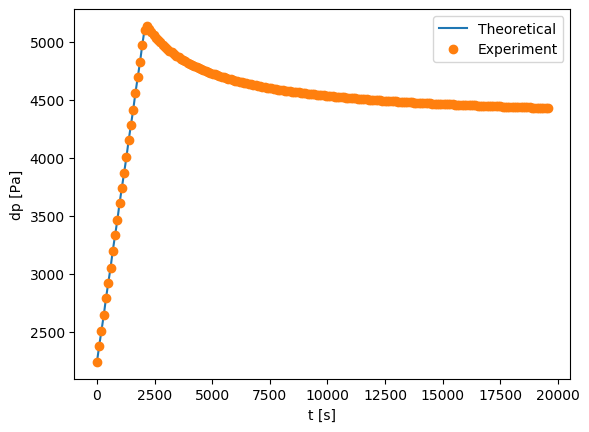

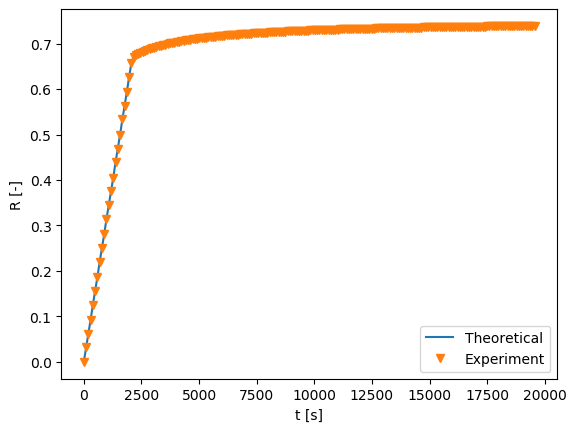

1.1439755442283902e-5

In [12]:
x_init = best_candidate(res)
vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

# Using JuMP
I'm going to try and use [JuMP](https://github.com/JuliaOpt/JuMP.jl) for history matching of core flooding data. I have used it previously for the history matching of foam flooding, but this is slightly different because there I ony had steady state data and did not need to solve a differential equation. Moreover, I could use automatic differentiation that is not possible to use here. 

In [14]:
using JuMP, Ipopt

In [33]:
# weight factors:
w_p = ones(length(exp_data1.dp_exp))
temp_val, ind_max = findmax(exp_data1.dp_exp)
# println(ind_max)
w_p[ind_max-1:ind_max+1] .= 10
w_p[end-10:end] .= 1
w_p[1]=1
w_R = ones(length(exp_data1.R_exp))
w_R[20:25] .= 1
w_R[end-10:end] .= 10

# [krw0, kro0, nw, no, swc, sor]

function my_f(krw0, kro0, nw, no, swc, sor)
    f_val = error_calc([krw0, kro0, nw, no, swc, sor], exp_data1, core_props, 
            fluids, core_flood, w_p = w_p, w_R = w_R)
    return f_val
end

function ∇f(g_val, krw0, kro0, nw, no, swc, sor)
    eps1 = 1e-4
    x = [krw0, kro0, nw, no, swc, sor]
    f_val = my_f(krw0, kro0, nw, no, swc, sor)
    g_val = zeros(length(x))
    for j in eachindex(x)
        x2 = copy(x)
        x2[j]+=eps1
        f_val2 = my_f(x2...)
        g_val[j] = (f_val2-f_val)/eps1
    end
    return g_val
end

# test
grad_x = zeros(6)
my_f(1.0, 0.8, 3, 4, 0.2, 0.2)

# ∇f(1.0, 0.8, 2, 2, 0.1, 0.2)

0.4548076217562965

In [34]:
model = Model(with_optimizer(Ipopt.Optimizer))
# [krw0, kro0, nw, no, swc, sor]
@variable(model, 0.1 <= kro0 <= 1.0, start = x_init[2])
@variable(model, 0.1 <= krw0 <= 1.0, start = x_init[1])
@variable(model, 0.01 <= sor <= 0.4, start = x_init[6])
@variable(model, 0.01 <= swc <= 0.4, start = x_init[5])
@variable(model, 1.0 <= no <= 4.0, start = x_init[4])
@variable(model, 1.0 <= nw <= 4.0, start = x_init[3])

register(model, :my_f, 6, my_f, ∇f)

@NLobjective(model, Min, my_f(krw0, kro0, nw, no, swc, sor))

# JuMP.register(model::Model, s::Symbol, dimension::Integer, f::Function,
#               ∇f::Function, ∇²f::Function)
# my_f(x, y) = (x - 1)^2 + (y - 2)^2
# function ∇f(g, x, y)
#     g[1] = 2 * (x - 1)
#     g[2] = 2 * (y - 2)
# end
JuMP.optimize!(model)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        6
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

InterruptException: InterruptException:

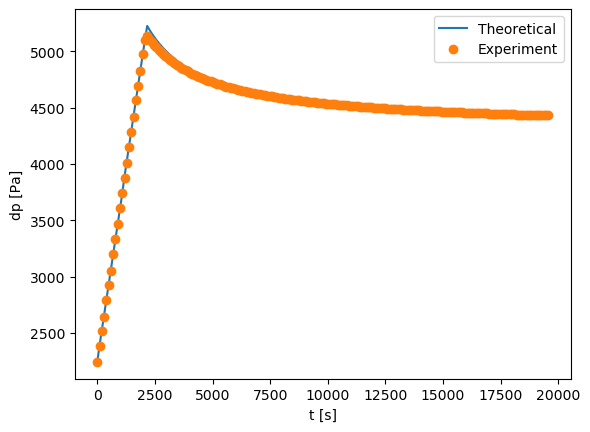

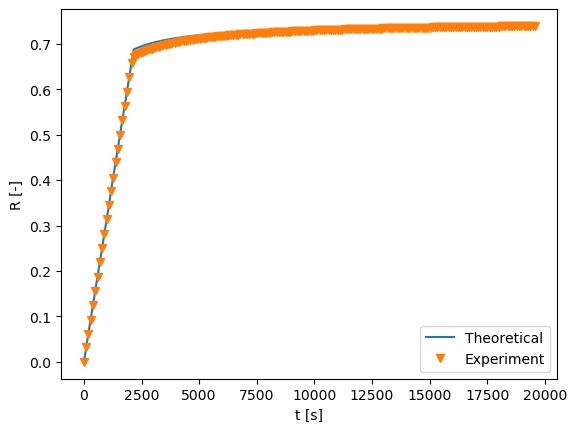

0.007544830494364934

In [28]:
x_init = [value(krw0), value(kro0), value(nw), value(no), value(swc), value(sor)]
vis_error(x_init, exp_data1, core_props, fluids, core_flood)
error_calc(x_init, exp_data1, core_props, fluids, core_flood)

In [18]:
x_init

6-element Array{Float64,1}:
 0.4412043349923931 
 0.9909989358955247 
 1.5007970424128223 
 2.902481118436997  
 0.13592685333937712
 0.14648578223980793